# Coffee Cup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.tri as tri

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (6, 6)

from fenics import *
from mshr import *

%run Utility.ipynb

We will now solve the unsteady heat equation on the mesh shown below:
![coffee_mesh](img/cup_mesh.png)

The unsteady heat equation in the strong form is
$$
\begin{align}
- \nabla^2 u(x, y, z) &= f(x, y, z), \\
u_{D} &= g(x, y, z) &\text{on}\ \ \Gamma_{D}, \\
\end{align}
$$
where
\begin{align}
f(x, y, z) &= 0,\\
g(x, y, z) &= 30 \qquad \text{on inner cup body}. \\
\end{align}

### Domain and Mesh

The coffee cup has already been defined for you through boolean operations on Cylinders from the mshr package. The thickness of the cup body is, $t = 0.1$

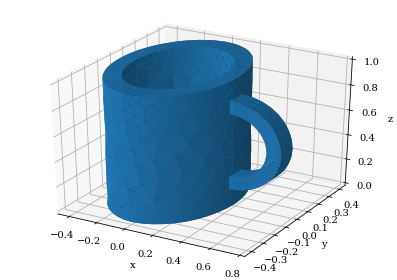

In [2]:
# Here's the mesh
outer_body = Cylinder(Point(0., 0., 0.), Point(0., 0., 1.), 0.4, 0.4)
inner_body = Cylinder(Point(0., 0.0, 0.1), Point(0., 0.0, 1.), 0.3, 0.3)
outer_handle = Cylinder(Point(0.4, -0.05, 0.5), Point(0.4, 0.05, 0.5), 0.35, 0.35)
inner_handle = Cylinder(Point(0.4, -0.05, 0.5), Point(0.4, 0.05, 0.5), 0.25, 0.25)

domain = (outer_body + (outer_handle - inner_handle)) - inner_body 
mesh = generate_mesh(domain, 10)

fig = plt.figure()
ax = fig.gca(projection='3d')
p = plot(mesh);
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.tight_layout();

In [3]:
# Please ignore... (calling meshing function from Utility)
mesh2d = cup_slice(tol = 1e-2)
V2 = FunctionSpace(mesh2d, 'P', 1)

### Function Space

Create a function space, `FunctionSpace(Mesh, FiniteElement, DOF)`, on the mesh defined above with a 'P' Finite Element with a degree of freedom 1.

In [4]:
V = FunctionSpace(mesh, 'P', 1)

### Boundary Conditions

Here's the complicated part! We expect a Dirichlet boundary condition of 60$^{\circ}$C on the inside of the cup body. (i.e. the cup is filled to the brim with 60$^{\circ}$C coffee). 

Here's the 2D slice of the cup showing the DirichletBC. Make a function that returns true on the blue boundary.

![cup_2d_slice](img/cup_2d_slice_bc.png)

Use the `DirichletBC()` function.

In [5]:
def boundary(x, on_boundary):
    '''
    This function indicates where the DirichletBC is defined on the mesh.
    x[0] = x, x[1] = y, x[2] = z
    '''
    r = 0.3
    n = near((x[0]*x[0] + x[1]*x[1]), r**2, 1e-2)
    t = near(x[2], 0.1)
    return n and on_boundary or (t and on_boundary)

u_D = Constant(60.0)
bc = DirichletBC(V, u_D, boundary)

### Initial Condition

The cup is initially at 18$^{\circ}$C. <br>
Set the initial condition and interpolate it over the FunctionSpace.

In [6]:
u_n = interpolate(Constant(18.0), V)

We set up a few parameters for the time-stepping section.

In [7]:
T = 20.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

### Setup Variational Formula

The variational problem for the unsteady heat equation with a backward Euler time stepping scheme is given below.

$$
\begin{equation}
\int_\Omega (u^{n+1}v + \kappa\Delta t\nabla u^{n+1} \cdot \nabla v)\,\text{d}x = \int_\Omega (u^n + \Delta t f^{n+1})v\,\text{d}x
\end{equation}
$$

where $\kappa = 5 \times 10^{-4}$ and $f = 0$ (the cup is not being forcefully heated/cooled by a source term).

Setup this equation in FEniCS. (Note that $u^{n}$ is the initial condition defined previously.)

In [8]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

k = 0.0005
a = (u*v + k*dt*inner(grad(u), grad(v)))*dx
L = (u_n + dt*f)*v*dx

### Solve the Equation

Solve the PDE within the time-stepping for loop and then update $u^{n}$ with the previous solution with the method `assign` on u_n.

(NOTE: If you want to rerun this cell you must reset u_n to the initial condition)

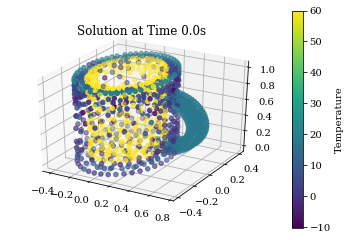

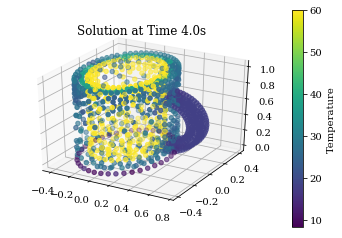

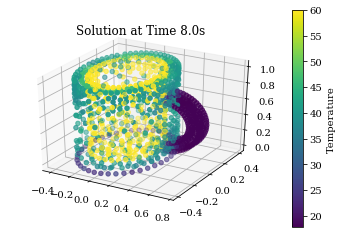

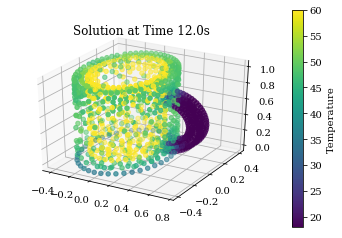

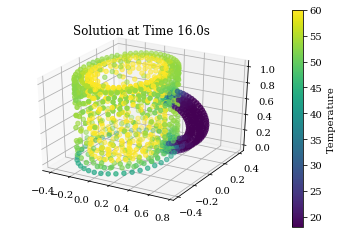

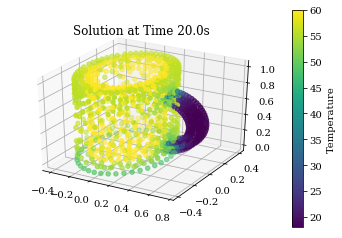

In [9]:
### Ignore this ###
coords = mesh2d.coordinates()
u_sols = []
u_sols_slice = []
time = []
###################

u_sol = Function(V)

for n in range(num_steps+1):
    '''
    '''
    # Solve the problem here
    solve(a == L, u_sol, bc)
    # Update u_n here
    u_n.assign(u_sol)
    
    ################# Please ignore... #################
    # These are for the animation plot later 
    time.append(dt*n)
    u_sols.append(u_sol.compute_vertex_values(mesh))
    
    u_f = []
    for j in range(V2.dim()):
        u_f.append(u_sol(coords[j][0], 0.0, coords[j][1]))
    u_sols_slice.append(u_f)
    ####################################################
    
    # This function plots the solution at progressively in time (in Utility)
    plot_time(n, u_sol, dt*n)

### Animation Plots

In [10]:
anim = animate(u_sols, time, mesh)
HTML(anim.to_html5_video())

In [11]:
anim_slice = animate_slice(u_sols_slice, time, mesh2d, V2)
HTML(anim_slice.to_html5_video())